In [1]:
![ ! -d "fmix" ] && git clone https://github.com/ecs-vlc/fmix

In [2]:
import os
import random
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import wandb
from dataset.affectnet import AffectNetDataset
from dataset.facialexpressions import FacialExpressionsDataset
from dataset.ferplus import FERPlusDataset
from dataset.rafdb import RAFDataset
from fmix_weight import FMix
from imgaug import augmenters as iaa
from layer.mish import MemoryEfficientMish, Mish
from layer.rademacher_dropout import RademacherDropout
from mish_cuda import MishCuda
from model.ab import AccuracyBoosterPlusBlock
from model.resnet import custom_resnet18, custom_resnet50
from model.se import SqueezeExcitationBlock
from optim.lookahead import Lookahead
from optim.lr_scheduler.FlatCosineAnnealing import FlatCosineAnnealing
from optim.radam import RAdam
from sklearn.metrics import accuracy_score, confusion_matrix
from torch import nn, optim
from torch.utils.data import (
    ConcatDataset,
    DataLoader,
    Dataset,
    WeightedRandomSampler,
    random_split,
)
from torchvision import models, transforms
from tqdm.auto import tqdm, trange
from trainer import Trainer

In [3]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.multiprocessing.set_sharing_strategy("file_system")
torch.set_deterministic(True)
# torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
torch.__version__

'1.7.0'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
WORKERS = cpu_count()

BATCH_TARGET = 256
BATCH_SIZE = 64
GRAD_ACC = BATCH_TARGET // BATCH_SIZE

MAX_STEP = 60_000
INFERENCE_BATCH_SIZE = BATCH_SIZE // 4

In [7]:
resize_transform = transforms.Resize(256)
centercrop_transform = transforms.CenterCrop(224)
tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


train_transform = transforms.Compose(
    [
        resize_transform,
        centercrop_transform,
        transforms.Resize(448)
        #         transforms.RandomHorizontalFlip(),
        #         transforms.ColorJitter(
        #             brightness=0.25, contrast=0.25, hue=0.05, saturation=0.05
        #         ),
        #         np.asarray,
        #         iaa.Sequential(
        #             [
        #                 iaa.Affine(rotate=(-15, 15), shear=(-15, 15), mode="symmetric"),
        #             ]
        #         ).augment_image,
        #         tensor_transform,
        #         normalize_transform,
    ]
)
predict_transform = transforms.Compose(
    [resize_transform, centercrop_transform, tensor_transform, normalize_transform]
)

In [8]:
trainset = ConcatDataset(
    [
        AffectNetDataset("../dataset/AffectNet", "train", transform=train_transform),
        #         FacialExpressionsDataset(
        #             "../dataset/facial_expressions", transform=train_transform
        #         ),
        #         FERPlusDataset("../dataset/FERPlus", "train", transform=train_transform),
        #         RAFDataset("../dataset/RAF-DB", "train", transform=train_transform),
    ]
)
len(trainset)

287651

In [9]:
res = []
col = []
for data in trainset:
    if data[1] == len(res):
        col.append(data[0])

    if len(col) == 3:
        res.append(col)
        col = []

    if len(res) == 8:
        break

len(res)

8

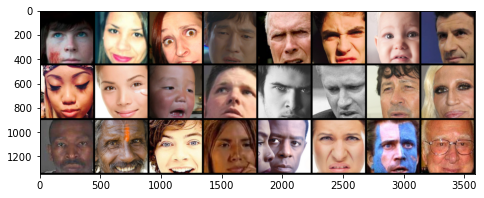

In [19]:
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (20,3)

plt.imshow(np.vstack([np.hstack([res[j][i] for j in range(8)]) for i in range(3)]))

In [11]:
classes = [
    "neutral",
    "happy",
    "surprise",
    "sad",
    "anger",
    "disgust",
    "fear",
    "contempt",
]
classes

['neutral', 'happy', 'surprise', 'sad', 'anger', 'disgust', 'fear', 'contempt']

In [12]:
n_samples = np.zeros(len(classes), dtype=int)

for innerset in trainset.datasets:
    for label in innerset.get_labels():
        n_samples[label] += 1

n_samples

array([ 74874, 134415,  14090,  25459,  24882,   3803,   6378,   3750])

In [13]:
normed_weights = [1 - (x / sum(n_samples)) for x in n_samples]
normed_weights = torch.FloatTensor(normed_weights).to(device)
normed_weights

tensor([0.7397, 0.5327, 0.9510, 0.9115, 0.9135, 0.9868, 0.9778, 0.9870],
       device='cuda:0')

In [14]:
target = [label for innerset in trainset.datasets for label in innerset.get_labels()]
class_sample_count = np.unique(target, return_counts=True)[1]
weight = 1.0 / class_sample_count
samples_weight = weight[target]
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [15]:
tensor_weight = torch.as_tensor(weight, dtype=torch.float, device=device)

In [16]:
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    drop_last=True,
    pin_memory=True,
    shuffle=True,
    #     sampler=sampler,
)

In [17]:
def show_dataset(dataset, n=5):
    pil_transform = transforms.ToPILImage()
    img = np.vstack(
        [
            np.hstack([pil_transform(dataset[i][0]) for _ in range(5)])
            for i in [random.randint(0, len(dataset)) for _ in range(n)]
        ]
    )
    plt.imshow(img)


show_dataset(trainset)

TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.

In [ ]:
affectnet_valset = AffectNetDataset(
    "../dataset/AffectNet", "val", transform=predict_transform
)
ferplus_valset = FERPlusDataset(
    "../dataset/FERPlus", "val", transform=predict_transform
)
ferplus_testset = FERPlusDataset(
    "../dataset/FERPlus", "test", transform=predict_transform
)
raf_testset = RAFDataset("../dataset/RAF-DB", "test", transform=predict_transform)

In [ ]:
valtestset = ConcatDataset(
    [
        affectnet_valset,
        ferplus_valset,
        ferplus_testset,
        raf_testset,
    ]
)
valsize = len(valtestset) // 2
valset, testset = random_split(valtestset, [valsize, len(valtestset) - valsize])

valloader = DataLoader(
    valset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
testloader = DataLoader(
    testset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
len(valset), len(testset)

In [ ]:
affectnet_valloader = DataLoader(
    affectnet_valset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
ferplus_valloader = DataLoader(
    ferplus_valset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
ferplus_testloader = DataLoader(
    ferplus_testset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)
raf_testloader = DataLoader(
    raf_testset,
    batch_size=INFERENCE_BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
)